In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def to_oersted(data):
    return data/79.9

In [3]:
# TODO: переименовать в `plot_data`
def plot_lines(*args, **kwargs):
    """
    Рисует графики. Пример (нарисует линии):
    >>> plot_lines(([1, 2], [2, 3], 'name'), ([3, 4, 5], [9, 16, 25], 'name2'))
    :param args: Кортеж из данных
    :param kwargs: Сюда можно передать 'title', и он отобразится в графике
    """
    title = kwargs.get('title')
    x_label, y_label = kwargs.get('x_label'), kwargs.get('y_label')
    is_scatter_global, save_to = kwargs.get('is_scatter'), kwargs.get('save_to')
    legend_position = kwargs.get('legend_position')
    if legend_position is None:
        legend_position = 'lower left'
    for (x_data, *y_data) in args:
        # Если передали title, то его
        has_label = False
        is_temp_reverse = False
        if len(y_data) == 2:
            has_label = True
            label = y_data[1]
            y_data = y_data[0]
        elif len(y_data) == 1:
            y_data = y_data[0]
        elif len(y_data) > 2:
            # Если передали, что это должна быть линия
            has_label = True
            label = y_data[1]
            y_data = y_data[0]
            is_temp_reverse = y_data[2]
        if is_temp_reverse:
            is_scatter = not is_scatter_global
        else:
            is_scatter = is_scatter_global
        if has_label:
            if not is_scatter:
                plt.plot(x_data, y_data, label=label)
            else:
                plt.scatter(x_data, y_data, label=label, marker='x')
            plt.legend(loc=legend_position)
        else:
            if not is_scatter:
                plt.plot(x_data, y_data)
            else:
                plt.scatter(x_data, y_data, marker='x')
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    plt.grid()
    if save_to:
        plt.savefig(save_to)
    plt.show()

In [4]:
df = pd.read_csv('dfpg_all.csv', sep=';')

In [5]:
df[df['I, A'] == 0.5]

,"field,G","intensity,a.u.","I, A"
0,3268.14,2039,0.5
1,3268.24,2039,0.5
2,3268.34,2042,0.5
3,3268.44,2043,0.5
4,3268.54,2044,0.5
5,3268.64,2046,0.5
6,3268.74,2044,0.5


## ДФПГ-спектр

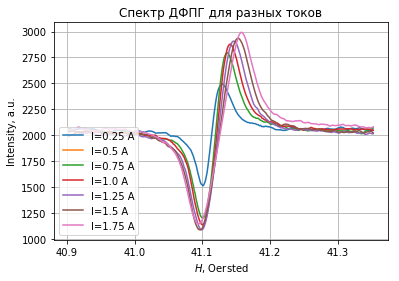

In [6]:
lines_data = []
for I in sorted(df['I, A'].unique()):
    lines_data.append((to_oersted(df[df['I, A'] == I]['field,G']),
                       df[df['I, A'] == I]['intensity,a.u.'], 
                       'I=%s A'%I))
plot_lines(
    *lines_data, 
    title='Спектр ДФПГ для разных токов', x_label=r'$H$, Oersted', y_label=r'Intensity, a.u.',
    save_to='dfpg.pdf'       
)

## Аппроксимация кривыми Гаусса и Лоренца

Будем считать, что все контуры лоренцевы и тогда
$$
\Delta H_\text{max} = \dfrac{2}{\sqrt{3}} \delta H
$$
Надо подсчитать $\Delta H_\text{max}$ как расстояние между экстремумами на графике, потом его вбить в эту формулу, получить $\delta H$, построить график $\delta H = f(I)$.

$\Delta H_\text{max}$ получим из анализа по программе из архива (привет, *Windows XP*).

In [7]:
df_deltaH = pd.read_csv('deltaH.csv', sep=';')
df_deltaH

,\Delta H,I,\delta H
0,2.253,0.25,1.062074
1,2.954,0.75,1.392529
2,3.354,1.00,1.581091
3,3.842,1.25,1.811136
4,4.618,1.50,2.176946
5,5.119,1.75,2.413120


In [8]:
def get_regression_results(data, x_label='ms', y_label='%'):
    """
    Считает линейную регрессию по данным и возвращает ее параметры:
    >>> get_regression_results([[1, 2, 3], [4, 5, 6]])
    :param data: Данные для регрессии, двумерный датафрейм
    :param x_label: Имя колонки, которая будет использована как 'x'
    :param y_label: Имя колонки, которая будет использована как 'y'
    :returns: (slope, intercept, std_err), reg_data
    """
    from scipy.stats import linregress
    import numpy as np
    x, y = data.copy()[x_label], data.copy()[y_label]
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    new_x = np.linspace(np.min(x)*0.9, np.max(x)*1.1, 10*5)
    new_y = new_x*slope + intercept
    return (slope, intercept, std_err), np.array([new_x, new_y])

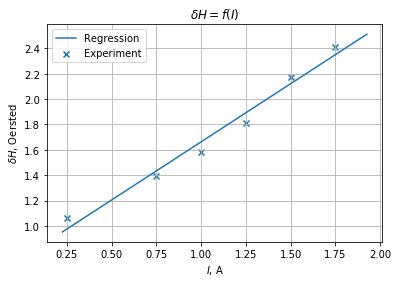

In [9]:
x, y = df_deltaH['I'], df_deltaH['\delta H']
(slope, intercept, std_err), new_data = get_regression_results(df_deltaH, x_label='I', y_label='\delta H')

plot_lines(
    (x, y, 'Experiment'),
    (*new_data, 'Regression', True),
    title=r'$\delta H = f(I)$', x_label=r'$I$, A', y_label=r'$\delta H$, Oersted', is_scatter=True,
    legend_position='upper left', save_to='deltaH_I.pdf'
)

In [10]:
print(slope)

0.9165720131428569


Вывод: с увеличением тока сигнал размазывается, поэтому разумно устанавливать ток модуляции не более 1,75 А. Максимально возможная амплитуда модуляции должна быть меньше максимально достижимой полуширины пика. Эта величина порядка 3,5 Э. 

## Зависимость $\delta H = f(C)$ для ионов $Mn^{2+}$

In [11]:
df_Mn = pd.read_csv('p2_deltaH_C.csv', sep=';')
df_Mn.head()

,DeltaH,C,deltaH
0,19.99,0.05,17.311848
1,18.91,0.10,16.376540
2,23.23,0.20,20.117770
3,25.39,0.40,21.988385
4,38.35,0.80,33.212074


$\gamma = 17.6 \cdot 10^6 \text{Oersted}^{-1}$

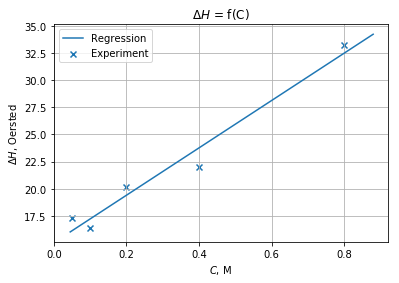

In [34]:
x, y = df_Mn['C'], df_Mn['deltaH']
(slope, intercept, std_err), new_data = get_regression_results(df_Mn, 'C', 'deltaH')
plot_lines(
    (x, y, 'Experiment'),
    (*new_data, 'Regression', True),
    title=r'$\Delta H$ = f(C)', is_scatter=True, legend_position='upper left',
    x_label=r'$C$, M', y_label=r'$\Delta H$, Oersted', save_to='delta_H_C.pdf'
)

In [35]:
print(slope)

21.773554833870968


In [14]:
K = slope*17.6*10**6
K

383214565.0761291

## Порошок соли $Mn^{2+}$

In [15]:
df_crystall = pd.read_csv('p2_crystal_Mn.epr.csv', sep=';')
df_crystall.head()

,"field,G","intensity,a.u."
0,3019.0,3523
1,3019.1,3526
2,3019.2,3524
3,3019.3,3526
4,3019.4,3525


In [16]:
# Перевод в Эрнстед
df_crystall['field,G'] = to_oersted(df_crystall['field,G'])

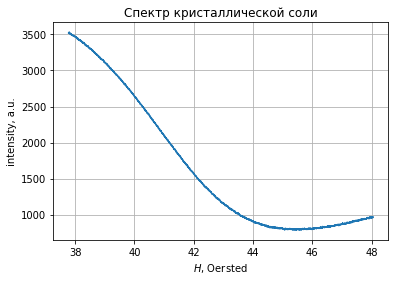

In [17]:
x, y = df_crystall['field,G'], df_crystall['intensity,a.u.']
plot_lines(
    (x, y),
    x_label=r'$H$, Oersted', y_label=r'intensity, a.u.', title=r'Спектр кристаллической соли',
    save_to='Crystalls.pdf'
)

## Порошок мела

In [65]:
df_mel = pd.read_csv('p3_mel.epr.csv', sep=';')
df_mel

,"field,G","intensity,a.u."
0,3019.00,2537
1,3019.10,2537
2,3019.20,2537
3,3019.30,2536
4,3019.40,2535
5,3019.50,2534
6,3019.60,2531
7,3019.70,2533
8,3019.80,2530
9,3019.90,2528


In [60]:
# Перевод в Эрстеды
df_mel['field,G'] = to_oersted(df_mel['field,G'])

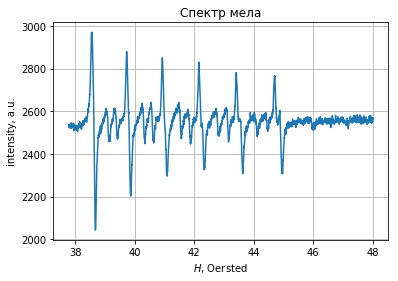

In [62]:
x, y = df_mel['field,G'], df_mel['intensity,a.u.']
plot_lines(
    (x, y),
    x_label=r'$H$, Oersted', y_label=r'intensity, a.u.', title=r'Спектр мела',
    save_to='mel.pdf'
)

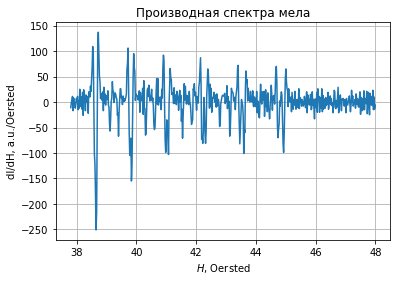

In [67]:
x_diff, y_diff = x[15::15], np.diff(y[::15])
plot_lines(
    (x_diff, y_diff),
    title='Производная спектра мела', x_label=r'$H$, Oersted', y_label=r'dI/dH, a.u./Oersted', save_to='mel_deriv.pdf'
)

## Исследование влияния уровня диэлектрических потерь на вид спектров

In [21]:
df_A, df_B, df_C = pd.read_csv('p4_A.epr.csv', sep=';'), pd.read_csv('p4_B.epr.csv', sep=';'), pd.read_csv('p4_C.epr.csv', sep=';')

In [22]:
df_A['field,G'] = to_oersted(df_A['field,G'])
df_B['field,G'] = to_oersted(df_B['field,G'])
df_C['field,G'] = to_oersted(df_C['field,G'])

In [23]:
df_A.head()

,"field,G","intensity,a.u."
0,37.784731,2310
1,37.785982,2306
2,37.787234,2302
3,37.788486,2300
4,37.789737,2294


In [24]:
df_B.head()

,"field,G","intensity,a.u."
0,37.784731,2223
1,37.785982,2224
2,37.787234,2224
3,37.788486,2225
4,37.789737,2224


In [25]:
df_C.head()

,"field,G","intensity,a.u."
0,37.784731,2193
1,37.785982,2171
2,37.787234,2147
3,37.788486,2133
4,37.789737,2126


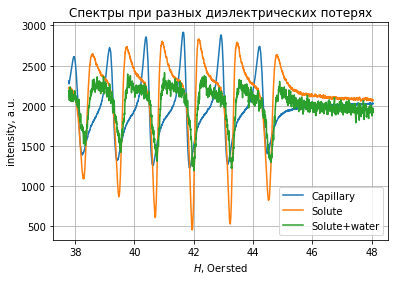

In [33]:
plot_lines(
    (df_A['field,G'], df_A['intensity,a.u.'], 'Capillary'),
    (df_B['field,G'], df_B['intensity,a.u.'], 'Solute'),
    (df_C['field,G'], df_C['intensity,a.u.'], 'Solute+water'),
    x_label=r'$H$, Oersted', y_label=r'intensity, a.u.', title=r'Спектры при разных диэлектрических потерях', 
    legend_position='lower right',
    save_to='dielect.pdf'
)

## Зависимость поглощения $S$ от концентрации

In [27]:
df_S = pd.read_csv('p2_S_C.csv', sep=';')
df_S

,C,"Y_max,mV","DeltaH,O",S
0,0.05,116.0,20.5,48749.0000
1,0.10,259.5,18.9,92695.9950
2,0.20,237.5,23.2,127832.0000
3,0.40,373.0,25.4,240644.6800
4,0.80,237.5,38.9,299489.4792


In [28]:
x, y = df_S['C'], df_S['S']/10**5

In [29]:
from scipy.optimize import curve_fit
x_pred = np.linspace(np.min(x),np. max(x), 10**4)
f_theor = lambda x, a, b, c: a - b/(1+c*x**2)

popt, pcov = curve_fit(f_theor, x, y)
f_opt = lambda x: f_theor(x, *popt)
y_pred = [f_opt(m) for m in x_pred]

In [30]:
popt

array([ 3.36417455,  2.87760541, 11.37904272])

In [31]:
rounded_coefs = [str(round(t, 2)) for t in popt]

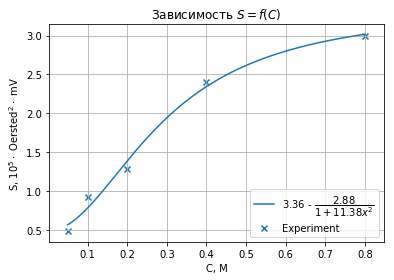

In [32]:
plot_lines(
    (x, y, 'Experiment'),
    (x_pred, y_pred , r'%s - $\dfrac{%s}{1 + %s x^2}$' % 
     (rounded_coefs[0], rounded_coefs[1], rounded_coefs[2]), True),
    x_label=r'C, M', y_label=r'S, $10^5 \cdot$ Oersted$^2 \cdot$ mV', is_scatter=True,
    legend_position='lower right', title=r'Зависимость $S = f(C)$',
    save_to='S_from_C.pdf'
)